In [1]:
%load_ext autoreload


In [2]:
%autoreload 2

In [20]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
'''Classes for Reading in the Data and applying Internal Normalisation'''
from nu_data_reduction import NU_data_read, int_norm, evaluation
import pylab as plt
from scipy import stats
#%pylab inline

In [4]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-08-30/"
#path = "/Users/marf 1/Desktop/PhD Temp/2016-07-25/"
path_sav = "/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/"
files_start = 4767
files_end = 4883


In [32]:
# cup configuration
#cup_config = cycle_Sb
cup_config = cycles2
# Isotopes used for Interference correction
corr_isotopes_1 = {"Cd" : "111", "Te" : "125"}
corr_isotopes_2 = {"Cd" : "111", "Te" : "125", "Xe" : "129"}
#corr_isotopes_2 = {}
corr_isotopes_Sb = {"Te": "125"}
# Mass Range of cup configuration
mass_range = cycles2_mass_range
# 122/118 norm
#isotopes = [["111", "112", "113", "114", "115", "116", "117", "119", "120", "122", "124", "125"]]
#isotope_column = ["111", "112", "113", "114", "115", "116", "117", "119", "120", "122", "124", "125"]
#data_sample_column = [(i + "/" + "118") for i in isotope_column]
#denom_isotope = "118"
#norm_ratio = ["122","118"]
# 116/120 norm
isotopes = [["111", "112", "113", "114", "115", "116", "117", "118", "119", "122", "124", "125"]]
isotope_column = ["111", "112", "113", "114", "115", "116", "117", "118", "119", "122", "124", "125"]
data_sample_column = [(i + "/" + "120") for i in isotope_column]
denom_isotope = "120"
norm_ratio = ["116","120"]

#number of iterations for beta
iter_beta = 10

# Interference_corr on the denominator isotope
isotope_denom_corr = False
# background correction
blk_corr = True

In [7]:
columns_1 = ["cycle", "sample", "date", "H8 (1)", "H7 (1)", "H6 (1)", "H5 (1)", "H4 (1)", "H3 (1)", "H2 (1)", "H1 (1)", "Ax (1)", "L1 (1)", "L2 (1)", "L3 (1)", "L4 (1)"]
columns_2 = ["cycle", "H8 (2)", "H7 (2)", "H6 (2)", "H5 (2)", "H4 (2)", "H3 (2)", "H2 (2)", "H1 (2)", "Ax (2)", "L1 (2)", "L2 (2)", "L3 (2)", "L4 (2)"]
df_all = pd.DataFrame()
blk_ls = []
sample_ls = []
files_1 = range(files_start, files_end, 1)
for sample in files_1:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    df_zero = df.data_zero_corr(sample)
    df_zero_1 = pd.DataFrame(df_zero["cycle1"])
    df_zero_2 = pd.DataFrame(df_zero["cycle2"])
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    df_zero_1["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    df_zero_1["sample"] = sample_name
    df_zero_1["cycle"] = df_zero_1.index.values
    df_zero_2["cycle"] = df_zero_2.index.values
    df_zero_1.index = df_zero_1["date"]
    df_zero_1 = df_zero_1[columns_1]
    df_zero_2 = df_zero_2[columns_2]
    df_all = df_all.append(df_zero_1.merge(df_zero_2), ignore_index = True)
    #df_all = df_all.append(df_zero_1, ignore_index = True)
    
    if sample_name == "blank sol" or sample_name == "wash" or sample_name == "wash clean" or sample_name == "Teflon blk":
        blk_ls.append(sample)
    elif sample_name == "SQ" or sample_name == "Teflon blk" or sample_name == "4ml HDPE blank":
        None
    else:
        sample_ls.append(sample)

df_all.set_index("date", inplace = True)
df_all
#for x in [123]:
#    sample_ls.remove(x)
#blk_ls = blk_ls[0::5]
#blk_ls.remove(4544)
df_all

,cycle,sample,H8 (1),H7 (1),H6 (1),H5 (1),H4 (1),H3 (1),H2 (1),H1 (1),...,H5 (2),H4 (2),H3 (2),H2 (2),H1 (2),Ax (2),L1 (2),L2 (2),L3 (2),L4 (2)
date,,,,,,,,,,,,,,,,,,,,,
2016-08-30 16:25:00,1,blank sol,0.002612,0.001976,0.014840,0.003623,0.009984,0.003145,0.006092,0.000122,...,0.000114,2.489580e-05,0.002689,0.000044,0.002049,0.000050,0.015243,0.003707,0.010252,0.003195
2016-08-30 16:25:00,2,blank sol,0.002408,0.001832,0.013722,0.003321,0.009186,0.002866,0.005585,0.000112,...,0.000084,2.490540e-05,0.002393,0.000041,0.001837,0.000025,0.013640,0.003304,0.009140,0.002885
2016-08-30 16:25:00,3,blank sol,0.002326,0.001784,0.013380,0.003216,0.008913,0.002792,0.005446,0.000094,...,0.000107,3.919370e-05,0.003596,0.000030,0.002765,0.000060,0.020172,0.004964,0.013808,0.004353
2016-08-30 16:25:00,4,blank sol,0.002470,0.001890,0.014190,0.003456,0.009572,0.003017,0.005763,0.000123,...,0.000087,3.204320e-05,0.002413,0.000041,0.001801,0.000006,0.013773,0.003305,0.009183,0.002914
2016-08-30 16:25:00,5,blank sol,0.002359,0.001781,0.013573,0.003276,0.009067,0.002853,0.005501,0.000111,...,0.000128,3.204950e-05,0.002794,0.000024,0.002121,0.000059,0.015704,0.003810,0.010601,0.003335
2016-08-30 16:25:00,6,blank sol,0.002323,0.001762,0.013307,0.003188,0.008878,0.002782,0.005399,0.000118,...,0.000094,2.705210e-05,0.002264,0.000052,0.001734,0.000066,0.012957,0.003088,0.008620,0.002763
2016-08-30 16:25:00,7,blank sol,0.002071,0.001517,0.011942,0.002817,0.007886,0.002476,0.004796,0.000101,...,0.000107,2.420700e-05,0.002177,0.000031,0.001668,0.000038,0.012445,0.002970,0.008248,0.002578
2016-08-30 16:25:00,8,blank sol,0.002277,0.001725,0.013015,0.003150,0.008677,0.002681,0.005246,0.000113,...,0.000115,1.991160e-05,0.002122,0.000029,0.001603,0.000067,0.012236,0.002911,0.008072,0.002562
2016-08-30 16:25:00,9,blank sol,0.002141,0.001592,0.012283,0.002961,0.008188,0.002587,0.004990,0.000114,...,0.000130,1.991770e-05,0.002096,0.000055,0.001605,0.000042,0.012209,0.002919,0.008050,0.002547


In [33]:
files_1 = range(files_start, files_end, 1)
df_raw_signals = pd.DataFrame()
df_internal_norm = pd.DataFrame()

for sample in sample_ls:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    # arbitrary blank positions
    blk1 = [item for item in blk_ls if item < sample]
    blk2 = [item for item in blk_ls if item > sample]
    blk1 = blk1[-1]
    blk2 = blk2[0]
    blk_corr_sample = True
    
    # blank measurement surrounds sample
    #if ((sample-1) in blk_ls) and ((sample+1) in blk_ls):
    #    blk1 = sample-1
    #    blk2 = sample+1
    #    blk_corr_sample = True
    #else:
    #    blk_corr_sample = False
    
    if (blk_corr == True) and (blk_corr_sample == True):
        blk_1 = NU_data_read(path, blk1, cup_config)
        blk_2 = NU_data_read(path, blk2, cup_config)
        df_zero = df.data_zero_corr(sample)
        df_bgd_1 = blk_1.data_zero_corr(blk1)
        df_bgd_2 = blk_2.data_zero_corr(blk2)   
        
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
        #df_bgd_1 = new_corr.mad_outlier_rejection_dict(df_bgd_1)
        #df_bgd_2 = new_corr.mad_outlier_rejection_dict(df_bgd_2)
        new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    else:
        df_zero = df.data_zero_corr(sample)
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
    
    data_sample_raw = new_corr.raw_signals(denom_isotope)
    data_sample_raw = pd.DataFrame.from_dict(data_sample_raw, orient = 'index')
    data_sample_raw = new_corr.mad_outlier_rejection(data_sample_raw)
    
    data_sample = new_corr.internal_norm_1(norm_ratio, denom_isotope, iter_beta)
    #data_sample = new_corr.raw_ratios_corr(denom_isotope)
    data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
    data_sample = new_corr.mad_outlier_rejection(data_sample)
    
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_sample = data_sample.drop(denom_isotope, axis=1)
    data_sample = data_sample[sorted(data_sample.columns)]
    data_sample.columns = data_sample_column
    data_sample["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_sample["sample"] = sample_name
    data_sample["cycle"] = data_sample.index.values
    
    data_sample_raw["cycle"] = data_sample_raw.index.values
    data_sample = data_sample.merge(data_sample_raw)
    
    df_internal_norm = df_internal_norm.append(data_sample)

In [34]:
df_internal_norm= df_internal_norm.set_index("date")
columns = ["cycle", "sample"]
columns.extend(data_sample_column)
columns.extend(sorted(data_sample_raw.drop("cycle", axis=1).columns))
df_internal_sub = pd.DataFrame(df_internal_norm, columns = columns)

df_internal_sub["Cd/Sn"] = (df_internal_norm["111"]/12.722)/(df_internal_norm["118"]/24.223)
df_internal_sub["Te/Sn"] = (df_internal_norm["125"]/7.0509)/(df_internal_norm["118"]/24.223)
#df_internal_sub["Te/Sn"] = (df_internal_norm["126"]/18.952)/(df_internal_norm["118"]/24.223)
#df_internal_sub = df_internal_sub[df_internal_sub["118"] >= 0.2]
#df_external_sub.to_csv(path_sav + "Sn_H9_L4_internal_corr_all.csv")

In [35]:
#df_internal_sub = df_internal_sub.drop(["2014-12-07 10:04:00"])
df_internal_norm

,111/120,112/120,113/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,...,114,117,116,111,125,113,112,124,119,118
date,,,,,,,,,,,,,,,,,,,,,
2016-08-30 16:37:00,NaN,0.029828,-4.731942e-07,NaN,0.010359,0.446,0.235329,0.743011,0.263498,0.142101,...,0.638906,7.752963,14.497975,NaN,0.000245,NaN,0.917906,6.405564,8.913435,24.805095
2016-08-30 16:37:00,0.000002,0.029821,-2.627115e-07,0.020189,0.010357,0.446,0.235330,0.743010,0.263497,0.142097,...,0.636351,7.723022,14.441588,0.000054,0.000260,NaN,0.914250,6.381800,8.879440,24.709803
2016-08-30 16:37:00,0.000002,0.029823,1.007217e-06,0.020191,0.010359,0.446,0.235335,0.743005,0.263489,0.142092,...,0.643011,7.803050,14.591183,0.000053,0.000260,0.000083,0.923839,6.446993,8.970691,24.964777
2016-08-30 16:37:00,0.000002,0.029822,4.237122e-07,0.020190,0.010360,0.446,0.235330,0.743006,0.263499,0.142095,...,0.637808,7.740055,14.473556,0.000059,0.000286,0.000070,0.916340,6.395434,8.898955,24.763986
2016-08-30 16:37:00,0.000002,0.029822,3.986158e-07,0.020191,0.010360,0.446,0.235329,0.743001,0.263497,0.142095,...,0.636767,7.726438,14.448473,0.000073,0.000260,0.000083,0.914838,6.383664,8.882963,24.720016
2016-08-30 16:37:00,0.000002,0.029823,7.251359e-07,0.020192,0.010361,0.446,0.235336,0.743003,0.263498,0.142094,...,0.647776,7.860861,14.699063,0.000054,0.000285,0.000075,0.930624,6.495130,9.037619,25.149841
2016-08-30 16:37:00,0.000002,0.029821,2.155167e-06,0.020190,0.010359,0.446,0.235333,0.743009,0.263497,0.142096,...,0.637856,7.740498,14.474507,0.000059,0.000275,0.000125,0.916452,6.394886,8.898927,24.764743
2016-08-30 16:37:00,0.000002,0.029824,1.303147e-06,0.020187,0.010359,0.446,0.235336,0.743000,0.263494,0.142094,...,0.633959,7.694023,14.387557,0.000060,0.000283,0.000099,0.911056,6.355890,8.845116,24.615195
2016-08-30 16:37:00,0.000002,0.029821,1.071763e-06,0.020188,0.010361,0.446,0.235325,0.742984,0.263497,0.142098,...,0.637105,7.732275,14.459298,0.000062,0.000276,0.000093,0.915392,6.389636,8.890195,24.739048


In [36]:
def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = 2 * np.std(x)
    return SD2

df_internal_norm_mean = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).mean()
df_internal_norm_mean_sd = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).agg([np.mean, SD2])
df_internal_norm_mean["sample"] = df_internal_sub[~df_internal_sub.index.duplicated(keep='first')]["sample"]
df_internal_norm_mean_sd["sample"] = df_internal_sub[~df_internal_sub.index.duplicated(keep='first')]["sample"]
#df_internal_norm_mean = df_internal_norm_mean.drop(datetime.strptime("20150310 23:59", "%Y%m%d %H:%M"))
#df_internal_norm_mean_sd = df_internal_norm_mean_sd[1:8]
df_internal_norm_mean
#epsilon = epsilon.drop(["118"], axis = 1)
#plotplot = df_internal_norm_mean[(df_internal_norm_mean["125"] < 0.00010)  & (df_internal_norm_mean["124/120"] > 0.17745)] 
#plot(plotplot["125"], plotplot["124/120"], "ro")

,111/120,112/120,113/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,...,117,118,119,120,122,124,125,Cd/Sn,Te/Sn,sample
date,,,,,,,,,,,,,,,,,,,,,
2016-08-30 16:37:00,0.000002,0.029823,6.906320e-07,0.020189,0.010361,0.446,0.235333,0.742998,0.263494,0.142095,...,7.728919,24.727374,8.885523,34.164241,4.981466,6.385373,0.000272,0.000005,0.000038,NIST 200ppb
2016-08-30 17:02:00,0.000003,0.027805,2.039755e-05,0.019500,0.010183,0.446,0.239435,0.768974,0.277553,0.155778,...,13.752361,43.997761,15.819467,56.797862,8.862541,11.359907,0.000470,0.000006,0.000037,NIST 350ppb
2016-08-30 17:28:00,0.000003,0.029822,-3.905427e-07,0.020189,0.010361,0.446,0.235333,0.742993,0.263490,0.142094,...,7.532054,24.097163,8.658953,33.293279,4.854355,6.222288,0.000253,0.000007,0.000036,NIST 200ppb
2016-08-30 17:43:00,0.000003,0.029822,-7.242497e-07,0.020188,0.010361,0.446,0.235332,0.742991,0.263489,0.142096,...,7.582153,24.257432,8.716439,33.514421,4.886622,6.263589,0.000269,0.000008,0.000038,NIST 200ppb
2016-08-30 17:57:00,0.000003,0.029823,2.242595e-07,0.020189,0.010361,0.446,0.235331,0.742985,0.263489,0.142094,...,7.758902,24.823788,8.920400,34.299589,5.001382,6.411276,0.000264,0.000007,0.000037,NIST 200ppb
2016-08-30 18:12:00,0.000003,0.029823,-8.150638e-07,0.020189,0.010361,0.446,0.235329,0.742958,0.263483,0.142091,...,10.690617,34.200394,12.289347,47.252052,6.889188,8.830095,0.000375,0.000006,0.000038,NIST 300ppb
2016-08-30 18:27:00,0.000003,0.029824,-6.671144e-07,0.020189,0.010361,0.446,0.235330,0.742982,0.263487,0.142094,...,7.374354,23.593745,8.478545,32.601553,4.754019,6.094280,0.000259,0.000008,0.000038,NIST 200ppb
2016-08-30 18:53:00,0.000003,0.029822,4.436453e-07,0.020189,0.010360,0.446,0.235329,0.742983,0.263497,0.142097,...,7.459208,23.866793,8.577435,32.982442,4.810135,6.167085,0.000281,0.000007,0.000040,NIST 200ppb
2016-08-30 19:08:00,0.000004,0.029822,7.144443e-07,0.020188,0.010361,0.446,0.235329,0.742976,0.263492,0.142095,...,7.237129,23.155208,8.321351,31.997327,4.666155,5.981966,0.000267,0.000009,0.000040,NIST 200ppb


In [37]:
df_internal_norm_sample_sd = df_internal_norm_mean.groupby(df_internal_norm_mean["sample"]).agg([np.mean, SD2])
df_internal_norm_sample_sd

111/120                 112/120                \
                               mean           SD2      mean           SD2   
sample                                                                      
NIST 200ppb                0.000003  7.192348e-07  0.029823  2.124009e-06   
NIST 200ppb + 0.005ppb U   0.000004  4.903787e-07  0.029822  4.802861e-07   
NIST 200ppb + 0.030ppb Cd  0.000046  3.081046e-07  0.029823  1.926182e-06   
NIST 200ppb + 0.04ppb Cd   0.000060  0.000000e+00  0.029823  0.000000e+00   
NIST 200ppb + 0.100ppb Zr  0.000004  0.000000e+00  0.029822  0.000000e+00   
NIST 200ppb + 0.150ppb Rh  0.000003  0.000000e+00  0.029824  0.000000e+00   
NIST 200ppb + 0.250ppb Pd  0.000003  1.083359e-06  0.029824  1.378155e-06   
NIST 200ppb + 0.300ppb Ru  0.000004  0.000000e+00  0.029824  0.000000e+00   
NIST 200ppb + 0.800ppb Mo  0.000003  8.573058e-07  0.029824  3.044007e-07   
NIST 200ppb + ME           0.000048  0.000000e+00  0.029824  0.000000e+00   
NIST 300ppb                0.000003  4.746547e-07  0.029824  1.368753e-06   
NIST 350ppb                0.000003  0.000000e+00  0.027805  0.000000e+00   
ZH09-05 23.3_1_3           0.000015  0.000000e+00  0.029825  0.000000e+00   
ZH09-05 23.3_3b_1          0.000034  1.485228e-05  0.029824  3.179081e-07   

                                113/120                 114/120                \
                                   mean           SD2      mean           SD2   
sample                                                                          
NIST 200ppb               -2.814742e-07  8.659219e-07  0.020189  1.952426e-06   
NIST 200ppb + 0.005ppb U  -4.782041e-07  6.225831e-07  0.020188  4.718329e-07   
NIST 200ppb + 0.030ppb Cd  1.285198e-07  6.649848e-07  0.020190  1.614929e-07   
NIST 200ppb + 0.04ppb Cd   3.082145e-07  0.000000e+00  0.020193  0.000000e+00   
NIST 200ppb + 0.100ppb Zr -7.993130e-07  0.000000e+00  0.020188  0.000000e+00   
NIST 200ppb + 0.150ppb Rh  6.459641e-08  0.000000e+00  0.020189  0.000000e+00   
NIST 200ppb + 0.250ppb Pd -8.440545e-08  8.162303e-08  0.020190  3.229767e-06   
NIST 200ppb + 0.300ppb Ru  5.911719e-08  0.000000e+00  0.020189  0.000000e+00   
NIST 200ppb + 0.800ppb Mo  2.504441e-07  9.263998e-07  0.020189  1.836987e-06   
NIST 200ppb + ME           1.428569e-07  0.000000e+00  0.020192  0.000000e+00   
NIST 300ppb               -2.472989e-07  6.047044e-07  0.020190  1.541244e-06   
NIST 350ppb                2.039755e-05  0.000000e+00  0.019500  0.000000e+00   
ZH09-05 23.3_1_3          -6.370431e-08  0.000000e+00  0.020191  0.000000e+00   
ZH09-05 23.3_3b_1         -2.417756e-07  2.368332e-08  0.020191  7.727534e-07   

                            115/120                    ...            122  \
                               mean           SD2      ...           mean   
sample                                                 ...                  
NIST 200ppb                0.010361  9.508838e-07      ...       4.672520   
NIST 200ppb + 0.005ppb U   0.010361  6.015801e-08      ...       4.743067   
NIST 200ppb + 0.030ppb Cd  0.010361  5.930139e-07      ...       4.580718   
NIST 200ppb + 0.04ppb Cd   0.010360  0.000000e+00      ...       4.460612   
NIST 200ppb + 0.100ppb Zr  0.010361  0.000000e+00      ...       4.543987   
NIST 200ppb + 0.150ppb Rh  0.010361  0.000000e+00      ...       4.633871   
NIST 200ppb + 0.250ppb Pd  0.010361  3.339322e-07      ...       4.617744   
NIST 200ppb + 0.300ppb Ru  0.010361  0.000000e+00      ...       4.445048   
NIST 200ppb + 0.800ppb Mo  0.010361  5.438537e-07      ...       4.620114   
NIST 200ppb + ME           0.010362  0.000000e+00      ...       4.451213   
NIST 300ppb                0.010361  3.633651e-07      ...       6.961502   
NIST 350ppb                0.010183  0.000000e+00      ...       8.862541   
ZH09-05 23.3_1_3           0.010360  0.000000e+00      ...       3.842925   
ZH09-05 23.3_3b_1          0.010359  1.469120e-06      ...       2.634411   

                              

In [56]:
df_internal_norm_mean.describe()


,111/118,112/118,113/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,...,116,117,118,119,120,122,124,126,Cd/Sn,Te/Sn
count,120.000000,120.000000,1.200000e+02,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,1.200000e+02,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.000434,0.040132,3.017158e-05,0.027177,0.014576,0.600298,0.316713,0.354610,1.346066,1.912496e-01,...,4.745849,2.535750,8.110452,2.913166,11.199200,1.632142,2.090978,0.003472,0.000753,0.000590
std,0.001700,0.000037,1.344293e-04,0.000098,0.002978,0.000044,0.000006,0.000011,0.000105,2.989150e-16,...,1.998933,1.068306,3.416765,1.227160,4.717407,0.687252,0.880233,0.014990,0.002947,0.002376
min,0.000013,0.039948,-5.563205e-05,0.026949,0.013941,0.600174,0.316688,0.354557,1.345978,1.912496e-01,...,0.366946,0.196096,0.627414,0.225399,0.866914,0.126366,0.161987,0.000175,0.000022,0.000017
25%,0.000030,0.040130,-2.439418e-06,0.027164,0.013948,0.600283,0.316710,0.354601,1.346023,1.912496e-01,...,4.698466,2.511901,8.034662,2.886412,11.096855,1.619523,2.077698,0.000262,0.000052,0.000037
50%,0.000032,0.040134,-1.143448e-06,0.027170,0.013957,0.600293,0.316713,0.354610,1.346038,1.912496e-01,...,4.963127,2.650470,8.478462,3.045722,11.711200,1.706818,2.187114,0.000294,0.000055,0.000048
75%,0.000086,0.040139,2.949299e-08,0.027173,0.013961,0.600301,0.316717,0.354619,1.346053,1.912496e-01,...,5.141233,2.748353,8.791874,3.158228,12.141019,1.768865,2.265643,0.000367,0.000149,0.000095
max,0.008539,0.040250,6.599913e-04,0.027612,0.028806,0.600491,0.316734,0.354630,1.346503,1.912496e-01,...,10.812061,5.780762,18.494954,6.644861,25.552500,3.725013,4.774185,0.076547,0.014807,0.011941


/Users/matthias/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2,center=False).mean()


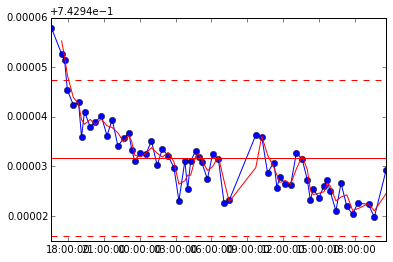

In [38]:
# variation of standard data + mean + 2SD
sel_ratio = "118/120"
plot_Nist = df_internal_norm_mean[df_internal_norm_mean["sample"] == "NIST 200ppb"]
plot_Nist = plot_Nist[(plot_Nist["118"] >= .5)]
#dataplot = plt.plot(plot_Nist["Te/Sn"], plot_Nist["124/118"], "ro")
plt.plot(plot_Nist.index, plot_Nist[sel_ratio], linestyle='-', marker='o', color='b')
plt.plot(plot_Nist.index, pd.rolling_mean(plot_Nist[sel_ratio], 2), linestyle='-', color='r')
plt.axhline(plot_Nist[sel_ratio].mean(), color='r', linestyle='-')
plt.axhline(plot_Nist[sel_ratio].mean()+ 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.axhline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
#dataplot = plt.plot(plot_Nist.index, plot_Nist["120"], "ro")
plt.show()

/Users/matthias/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2,center=False).mean()


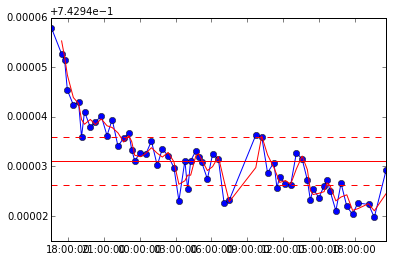

In [39]:
# variation of standard data + meadian + 25% quantile + 75% quantile
sel_ratio = "118/120"
plot_Nist = df_internal_norm_mean[df_internal_norm_mean["sample"] == "NIST 200ppb"]
plot_Nist = plot_Nist[(plot_Nist["118"] >= .5)]
#dataplot = plt.plot(plot_Nist["Te/Sn"], plot_Nist["124/118"], "ro")
plt.plot(plot_Nist.index, plot_Nist[sel_ratio], linestyle='-', marker='o', color='b')
plt.plot(plot_Nist.index, pd.rolling_mean(plot_Nist[sel_ratio], 2), linestyle='-', color='r')
plt.axhline(plot_Nist[sel_ratio].median(), color='r', linestyle='-')
plt.axhline(plot_Nist[sel_ratio].quantile(0.25), color='r', linestyle='--')
plt.axhline(plot_Nist[sel_ratio].quantile(0.75), color='r', linestyle='--')
#dataplot = plt.plot(plot_Nist.index, plot_Nist["120"], "ro")
plt.show()

/Users/matthias/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2,center=False).mean()


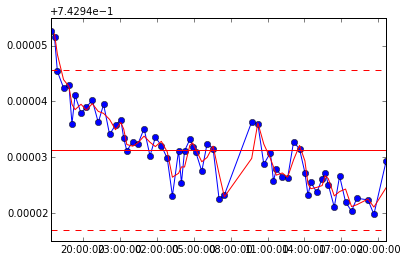

In [40]:
# outlier corr variation of standard data + meadian + 25% quantile + 75% quantile
sel_ratio = "118/120"
plot_Nist = df_internal_norm_mean[df_internal_norm_mean["sample"] == "NIST 200ppb"]
plot_Nist = new_corr.mad_outlier_rejection(plot_Nist.drop("sample", axis=1))
plot_Nist = plot_Nist[(plot_Nist["118"] >= .5)]
#dataplot = plt.plot(plot_Nist["Te/Sn"], plot_Nist["124/118"], "ro")
plt.plot(plot_Nist.index, plot_Nist[sel_ratio], linestyle='-', marker='o', color='b')
plt.plot(plot_Nist.index, pd.rolling_mean(plot_Nist[sel_ratio], 2), linestyle='-', color='r')
plt.axhline(plot_Nist[sel_ratio].mean(), color='r', linestyle='-')
plt.axhline(plot_Nist[sel_ratio].mean()+ 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.axhline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
#dataplot = plt.plot(plot_Nist.index, plot_Nist["120"], "ro")
plt.show()

In [41]:
sub_index = df_internal_norm_mean[(df_internal_norm_mean["sample"].shift(1) == df_internal_norm_mean["sample"].shift(-1)) & (df_internal_norm_mean["sample"].shift(1) == "NIST 200ppb")].index
#corr_values = df_internal_norm_mean[(df_external_norm_mean >= 0.74289)]
#corr_values = df_internal_norm_mean[:"20150110 10:00"]
corr_values = df_internal_norm_mean[df_internal_norm_mean["118"] >= 1]
corr_values_2 = corr_values[corr_values["sample"] == "NIST 200ppb"]
#corr_values = df_internal_norm_mean
sample = corr_values["sample"]
sample_2 = corr_values_2["sample"]
std_mean = corr_values[(corr_values["sample"] == "NIST 100ppb")].mean()
new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

#std_mean["112/120", "114/120", "115/120", "117/120", "118/120", "119/120", "122/120", "124/120"] = [0.029823, 0.020189, 0.010372, 0.235299, 0.742923, 0.263443, 0.142078, 0.177546]
#print std_mean
#epsilon =  ((new / std_mean)-1)*10000
#new["sample"] = sample
epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*10000
epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*10000
epsilon_NIST["sample"] = sample
epsilon_2["sample"] = sample

epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"] != "NIST 200ppb"]
epsilon_2 = epsilon_2[epsilon_2["sample"] == "NIST 200ppb"]
epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
#epsilon_comp.index = epsilon_comp["Date"]
#epsilon_comp.columns
epsilon_comp

,111/120,112/120,113/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,...,117,118,119,120,122,124,125,Cd/Sn,Te/Sn,sample
date,,,,,,,,,,,,,,,,,,,,,
2016-08-30 17:02:00,-506.970376,-676.529037,1.349432e+06,-341.539286,-171.623808,0.000000e+00,174.308853,349.652588,533.620963,962.973464,...,8022.914908,8022.807326,8033.558617,6839.594032,8020.948173,8020.641036,7897.233110,-239.843652,-97.773095,NIST 350ppb
2016-08-30 18:12:00,-771.222982,0.052448,2.680952e+04,-0.095106,0.149862,0.000000e+00,-0.048239,-0.342324,-0.179663,-0.194859,...,4128.641405,4127.276413,4126.542935,4125.932764,4123.843904,4121.874341,4333.888559,-928.400138,54.111174,NIST 300ppb
2016-08-30 19:38:00,1129.261942,-0.265075,-6.933156e+03,-0.553191,0.148857,-1.110223e-12,-0.045484,-0.443076,-0.143504,-0.117505,...,5039.819848,5039.371123,4997.316772,4997.676287,4965.227067,4965.416226,5090.929679,1149.082828,-62.197739,NIST 300ppb
2016-08-30 20:33:00,-1272.400336,0.292945,-5.627456e+04,0.541676,-0.117280,-1.110223e-12,0.039821,-0.027682,-0.022995,-0.174609,...,-208.556737,-208.627573,-208.640012,-208.639923,-208.806845,-208.896659,-137.511804,-1358.832995,130.850282,NIST 200ppb + 0.800ppb Mo
2016-08-30 21:02:00,-311.658309,0.160720,-1.940646e+03,0.014617,-0.226869,0.000000e+00,-0.054702,0.019178,0.002993,-0.007258,...,-269.743707,-269.744065,-269.786560,-269.811332,-269.836147,-269.856262,-319.837938,-311.121842,-53.062257,NIST 200ppb + 0.250ppb Pd
2016-08-30 21:57:00,118599.240975,0.468207,-6.529285e+03,0.952404,0.666164,2.220446e-12,-0.016990,-0.064940,-0.106685,-0.150995,...,-375.422513,-375.676398,-375.912553,-376.032278,-376.631377,-377.044864,-1234.962262,118090.949696,-908.357636,NIST 200ppb + 0.030ppb Cd
2016-08-30 22:26:00,1497.262801,-0.390802,4.206793e+03,-0.130573,0.211669,-1.110223e-12,0.009522,0.044329,0.103744,-0.051800,...,-142.081520,-141.945359,-141.773453,-141.828307,-141.677129,-141.548034,-85.958394,1244.450857,91.570890,NIST 200ppb + 0.005ppb U
2016-08-30 23:50:00,-542.975396,-0.053990,-1.417268e+04,0.112940,-0.137539,-1.110223e-12,-0.123985,-0.383127,-0.120573,-0.162656,...,5290.180496,5289.875999,5290.405272,5290.723376,5290.733617,5290.995990,5494.906874,-542.915728,136.171412,NIST 300ppb
2016-08-31 00:44:00,1219.384628,0.218328,-1.117489e+04,0.291360,-0.573159,0.000000e+00,-0.022958,-0.021638,-0.040896,-0.216409,...,-415.999500,-416.084286,-416.140909,-416.196491,-416.536985,-416.600192,-488.797246,815.901209,-115.908019,NIST 200ppb + 0.300ppb Ru


In [42]:
def SD2(x):
    SD2 = np.std(x) * 2
    return SD2

epsilon = epsilon_comp.drop(["111", "125", "112", "114", "115", "116", "117", "118", "119", "120", "122", "124", "Cd/Sn", "Te/Sn"], axis = 1)
#epsilon = epsilon.drop(["118"], axis = 1)
epsilon_sum = np.round(epsilon.groupby("sample").agg([np.mean, SD2]), decimals=2)
epsilon_sum

111/120           112/120           113/120  \
                                mean       SD2    mean   SD2        mean   
sample                                                                     
NIST 200ppb                    57.93   2239.01    0.00  0.57   -66086.94   
NIST 200ppb + 0.005ppb U      711.77   1570.99   -0.18  0.41     -729.52   
NIST 200ppb + 0.030ppb Cd  125048.30  12898.12    0.22  0.50   -14652.94   
NIST 200ppb + 0.04ppb Cd   171153.56      0.00    0.24  0.00   -17440.37   
NIST 200ppb + 0.100ppb Zr    1866.27      0.00   -0.42  0.00  4986880.84   
NIST 200ppb + 0.150ppb Rh   -1242.92      0.00    0.53  0.00   -10696.75   
NIST 200ppb + 0.250ppb Pd   -2139.85   3656.39    0.30  0.28    -5441.02   
NIST 200ppb + 0.300ppb Ru    1219.38      0.00    0.22  0.00   -11174.89   
NIST 200ppb + 0.800ppb Mo    -490.89   1563.02    0.37  0.15   -30624.07   
NIST 200ppb + ME           145734.22      0.00    0.00  0.00   -22141.90   
NIST 300ppb                  -419.05   1710.73    0.07  0.59    -9989.26   
NIST 350ppb                  -506.97      0.00 -676.53  0.00  1349432.27   
ZH09-05 23.3_1_3            42128.42      0.00    0.48  0.00    -7797.83   
ZH09-05 23.3_3b_1           99341.13  47445.93    0.13  0.64    -4973.42   

                                      114/120       115/120          ...     \
                                  SD2    mean   SD2    mean   SD2    ...      
sample                                                               ...      
NIST 200ppb                1092804.73    0.00  0.89   -0.01  0.88    ...      
NIST 200ppb + 0.005ppb U      9872.62    0.08  0.41    0.26  0.10    ...      
NIST 200ppb + 0.030ppb Cd    16247.30    0.96  0.01    0.54  0.26    ...      
NIST 200ppb + 0.04ppb Cd         0.00    2.40  0.00   -0.94  0.00    ...      
NIST 200ppb + 0.100ppb Zr        0.00   -0.63  0.00    0.25  0.00    ...      
NIST 200ppb + 0.150ppb Rh        0.00    0.94  0.00   -0.29  0.00    ...      
NIST 200ppb + 0.250ppb Pd     7000.74    0.51  1.00   -0.60  0.76    ...      
NIST 200ppb + 0.300ppb Ru        0.00    0.29  0.00   -0.57  0.00    ...      
NIST 200ppb + 0.800ppb Mo    51300.98   -0.15  1.39   -0.05  0.13    ...      
NIST 200ppb + ME                 0.00    1.43  0.00    0.77  0.00    ...      
NIST 300ppb                  59462.63    0.15  0.58    0.10  0.41    ...      
NIST 350ppb                      0.00 -341.54  0.00 -171.62  0.00    ...      
ZH09-05 23.3_1_3                 0.00    0.36  0.00   -0.69  0.00    ...      
ZH09-05 23.3_3b_1              278.46    0.51  0.26   -1.52  1.00    ...      

                          119/120       122/120        124/120        125/120  \
                             mean   SD2    mean   SD2     mean   SD2     mean   
sample                                                                          
NIST 200ppb                 -0.00  0.20   -0.00  0.19    -0.01  0.34    -2.48   
NIST 200ppb + 0.005ppb U     0.12  0.02   -0.01  0.09    -0.01  0.20    19.29   
NIST 200ppb + 0.030ppb Cd   -0.06  0.09   -0.04  0.23    -0.05  0.28  -443.81   
NIST 200ppb + 0.04ppb Cd    -0.15  0.00   -0.13  0.00    -0.22  0.00   -87.40   
NIST 200ppb + 0.100ppb Zr   -0.01  0.00   -0.08  0.00    -0.05  0.00   764.04   
NIST 200ppb + 0.150ppb Rh   -0.05  0.00   -0.14  0.00    -0.17  0.00  -157.51   
NIST 200ppb + 0.250ppb Pd    0.00  0.01    0.07  0.15     0.07  0.05 -2770.34   
NIST 200ppb + 0.300ppb Ru   -0.04  0.00   -0.22  0.00    -0.15  0.00   -83.54   
NIST 200ppb + 0.800ppb Mo   -0.04  0.03   -0.12  0.11    -0.12  0.21   458.77   
NIST 200ppb + ME             0.16  0.00   -0.06  0.00    -0.21  0.00  -469.14   
NIST 300ppb                 -0.13  0.09   -0.14  0.19    -0.17  0.27    22.56   
NIST 350ppb                533.62  0.00  962.97  0.00  1297.21  0.00  1419.67   
ZH09-05 23.3_1_3            -0.26  0.00   -0.54  0.00    -0.77  0.00  -159.43   
ZH09-05 23.3_3b_1           -0.30  0.05   -0.36  0.18    -0.46  0.27   740.37   

              

In [130]:
epsilon_comp[epsilon_comp["sample"]== "NIST 200ppb"]["118/120"].mean()

-0.0016634003179120487

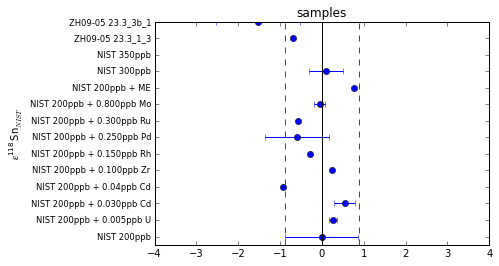

In [56]:
sel_ratio = "115/120"
x = range(1, len(epsilon_sum.index)+1)
plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
plt.title("samples")
plt.xlim([-4, 4])
plt.ylim([0.5, 3.0])
plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
plt.axvline(epsilon_comp[epsilon_comp["sample"]== "NIST 200ppb"][sel_ratio].mean(), color='k', linestyle='-')
plt.axvline(epsilon_comp[epsilon_comp["sample"]== "NIST 200ppb"][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== "NIST 200ppb"][sel_ratio].std(), color='r', linestyle='--')
plt.axvline(epsilon_comp[epsilon_comp["sample"]== "NIST 200ppb"][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== "NIST 200ppb"][sel_ratio].std(), color='r', linestyle='--')
#plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{118}}$Sn$_{NIST}$')
#savefig(path+"epsilon_118.pdf", bbox_inches='tight')

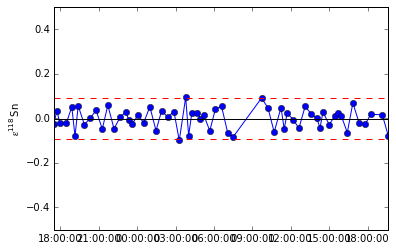

In [44]:
sel_ratio = "118/120"
epsilon_comp = epsilon_comp[epsilon_comp["sample"] == "NIST 200ppb"]
x = epsilon_comp.index
plt.plot(x, epsilon_comp[sel_ratio], marker="o")
plt.ylim([-0.5, 0.5])
#plt.xticks(x, epsilon_comp["sample"], size='small', rotation=90)
plt.axhline(epsilon_comp[sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[sel_ratio].mean()+ 2*epsilon_comp[sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[sel_ratio].mean()- 2*epsilon_comp[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{118}}$Sn')
#savefig(path+"epsilon_119.pdf", bbox_inches='tight')

In [29]:
df_all.to_csv(path + "Sn_H9_L4_1_cycles_NU_Signals_zero_corr.csv", mode='w', header=True)

In [45]:
df_internal_norm.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_116_120_bdg_corr_all.csv", mode='w', header=True)

In [46]:
df_internal_norm_mean_sd.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_116_120_bdg_corr.csv", mode='w', header=True)

In [103]:
df_std.to_csv(path_sav + "All_standards_internal_norm_mean.csv")

NameError: name 'df_std' is not defined

In [986]:
df_all_mean_1 = pd.read_csv(path_sav + "Sn_H9_L4_1_cycles_internal_norm_mean.csv")

In [987]:
df_all_mean_2 = pd.read_csv(path_sav + "Sn_H8_L4_2_cycles_internal_norm_mean.csv")

In [1088]:
df_mean_all = df_all_mean_1.append(df_all_mean_2)

In [30]:
#old Cd/Sn & Te/Sn extraction - doesn't include bgd corr
df_internal_norm= df_internal_norm.set_index("date")
columns = ["cycle", "sample"]
columns.extend(data_sample_column)
columns.extend(sorted(data_sample_raw.drop("cycle", axis=1).columns))
df_internal_sub = pd.DataFrame(df_internal_norm, columns = columns)

df_all_sub = df_all[(df_all["sample"] != "blank sol") & (df_all["sample"] != "SQ") & (df_all["sample"] != "teflon blank")]
df_internal_sub["111"] = df_all_sub["L3 (1)"]
df_internal_sub["125"] = df_all_sub["H5 (2)"]
df_internal_sub["Cd/Sn"] = (df_all_sub["L3 (1)"]/12.722)/(df_all_sub["H4 (1)"]/24.223)
df_internal_sub["Te/Sn"] = (df_all_sub["H5 (2)"]/7.0509)/(df_all_sub["H4 (1)"]/24.223)
#df_external_sub.to_csv(path_sav + "Sn_H9_L4_internal_corr_all.csv")

In [1089]:
df_mean_all = df_mean_all[2:]
df_mean_all.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
df_mean_all = df_mean_all[["Date", "112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118","sample"]]
df_mean_all = df_mean_all.set_index("Date") 

In [1182]:
df_std = df_mean_all[(df_mean_all["sample"] == "SPEX1 100ppb") | (df_mean_all["sample"] == "SPEX 100ppb") | (df_mean_all["sample"] == "NIST 100ppb")]
df_std

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,118,sample
Date,,,,,,,,,,,
2014-10-07 20:49:00,0.0298238495726,0.0201845997439,0.0103681594438,0.446,0.235295696368,0.742939518097,0.263445942562,0.142086185109,0.177571556759,10.1619395381,SPEX1 100ppb
2014-10-07 21:07:00,0.0298270855009,0.0201887834143,0.0103664239291,0.446,0.235295260593,0.742937654621,0.263447680516,0.14208571056,0.177573088542,10.2834847296,SPEX1 100ppb
2014-10-07 21:29:00,0.0298241010738,0.0201850728708,0.0103667030734,0.446,0.235295046713,0.742937732217,0.263449417694,0.142085954225,0.17757007419,10.0068814188,SPEX1 100ppb
2014-10-07 21:46:00,0.0298269719657,0.0201827454973,0.0103676568054,0.446,0.235297077525,0.742936157145,0.263450048386,0.142089277895,0.177573191934,10.1732362802,SPEX1 100ppb
2014-11-18 18:22:00,0.0298319477344,0.0201968060654,0.0103609914838,0.446,0.235308007067,0.74295144542,0.263456437295,0.142073025422,0.17753393783,11.9205622223,NIST 100ppb
2014-11-18 18:27:00,0.0298302415426,0.0202014506204,0.0103609667001,0.446,0.235304600881,0.742949759778,0.263451222795,0.142074064497,0.177531032284,11.8435340427,NIST 100ppb
2014-11-18 18:31:00,0.029834566445,0.0202024281122,0.0103608586407,0.446,0.235309236679,0.742955467382,0.263452936054,0.142073215452,0.177533064574,11.3634385069,NIST 100ppb
2014-11-18 18:36:00,0.0298236482085,0.0201946006554,0.0103617565758,0.446,0.235308318118,0.742946848523,0.263449990275,0.142074569672,0.177530832831,11.5416992302,NIST 100ppb
2014-11-18 18:40:00,0.0298227478429,0.0201921659888,0.0103615705949,0.446,0.235307461611,0.742950591745,0.263450041891,0.142075223065,0.177536326791,11.6314409578,NIST 100ppb


In [1183]:
df_std[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118"]] = df_std[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118"]].astype(float)
df_std.index = df_std.index.astype(datetime64)
df_std = df_std[(df_std.index < pd.Timestamp('2015-03-10')) | (df_std.index > pd.Timestamp('2015-03-12'))]
df_std = df_std[(df_std.index < pd.Timestamp('2014-11-29 18:25:00')) | (df_std.index > pd.Timestamp('2014-11-29 20:27:00'))]
df_std

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,118,sample
Date,,,,,,,,,,,
2014-10-07 18:49:00,0.029824,0.020185,0.010368,0.446,0.235296,0.742940,0.263446,0.142086,0.177572,10.161940,SPEX1 100ppb
2014-10-07 19:07:00,0.029827,0.020189,0.010366,0.446,0.235295,0.742938,0.263448,0.142086,0.177573,10.283485,SPEX1 100ppb
2014-10-07 19:29:00,0.029824,0.020185,0.010367,0.446,0.235295,0.742938,0.263449,0.142086,0.177570,10.006881,SPEX1 100ppb
2014-10-07 19:46:00,0.029827,0.020183,0.010368,0.446,0.235297,0.742936,0.263450,0.142089,0.177573,10.173236,SPEX1 100ppb
2014-11-18 17:22:00,0.029832,0.020197,0.010361,0.446,0.235308,0.742951,0.263456,0.142073,0.177534,11.920562,NIST 100ppb
2014-11-18 17:27:00,0.029830,0.020201,0.010361,0.446,0.235305,0.742950,0.263451,0.142074,0.177531,11.843534,NIST 100ppb
2014-11-18 17:31:00,0.029835,0.020202,0.010361,0.446,0.235309,0.742955,0.263453,0.142073,0.177533,11.363439,NIST 100ppb
2014-11-18 17:36:00,0.029824,0.020195,0.010362,0.446,0.235308,0.742947,0.263450,0.142075,0.177531,11.541699,NIST 100ppb
2014-11-18 17:40:00,0.029823,0.020192,0.010362,0.446,0.235307,0.742951,0.263450,0.142075,0.177536,11.631441,NIST 100ppb


In [1184]:
df_std = df_std[(df_std["118"] > 5) & (df_std["118/120"] > 0.7428)]
for i in df_std.index[df_std["sample"] == "SPEX1 100ppb"]:
    df_std.ix[i, "sample"] = "SPEX 100ppb"

In [1220]:
sample = df_std["sample"]
std_mean = df_std[(df_std["sample"] == "SPEX 100ppb")].mean()
new = df_std[df_std.columns[df_std.dtypes != 'object']]
epsilon =  ((new / std_mean)-1)*10000
epsilon["sample"] = sample
epsilon
epsilon[(epsilon["118/120"] > 0.4) | (epsilon["118/120"] < -0.4)]

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,118,sample
Date,,,,,,,,,,,
2014-11-18 18:54:00,-1.295126,-1.053575,1.608025,1.998401e-11,-1.180555,-0.463371,-0.356364,0.722133,2.010156,1309.494419,SPEX 100ppb
2014-12-06 22:37:00,-4.936059,-7.445774,1.331682,1.998401e-11,0.786625,0.539985,1.003885,0.222717,0.767402,-1614.119882,SPEX 100ppb
2014-12-06 22:52:00,-1.620072,-3.896472,0.536870,1.998401e-11,0.533814,0.527568,1.004705,0.469725,1.664357,-1804.778746,SPEX 100ppb
2014-12-06 23:08:00,-2.641746,-4.386719,2.125820,1.998401e-11,0.522416,0.475452,0.892735,0.462190,1.555222,-1848.039153,SPEX 100ppb
2014-12-06 23:23:00,-3.243182,-3.908338,-0.299309,1.998401e-11,0.613841,0.489401,0.951723,0.466426,1.660720,-1728.263406,SPEX 100ppb
2014-12-06 23:39:00,-3.174104,-5.626922,2.187946,1.998401e-11,0.711496,0.500329,0.913301,0.302836,1.500547,-1512.382276,SPEX 100ppb
2014-12-06 23:54:00,-2.499252,-3.686348,3.196847,1.998401e-11,0.532245,0.565307,0.943385,0.268384,1.570411,-1442.654967,SPEX 100ppb
2014-12-07 00:09:00,-3.167063,-4.997893,0.608021,1.998401e-11,0.745353,0.520016,1.039127,0.455542,1.559710,-1523.698889,SPEX 100ppb
2014-12-07 00:25:00,-2.027759,-4.105014,2.820000,1.998401e-11,0.605650,0.507195,0.913818,0.470145,1.538801,-1719.373397,SPEX 100ppb


In [1222]:
lee = pd.DataFrame({"112/120" : pd.Series(0.029812), "114/120" : pd.Series(0.020195), "115/120": pd.Series(0.010366), "116/120": pd.Series(0.4460), "117/120" : pd.Series(0.235313), "118/120" : pd.Series(0.742935), "119/120" : pd.Series(0.263430), "122/120" : pd.Series(0.142086), "124/120" : pd.Series(0.177588)})
epsilon_lee = ((lee / std_mean[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120"]])-1)*10000
epsilon_lee["sample"] = "Lee et al. (1995)"
epsilon_lee

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,sample
0,-4.252887,1.76055,-2.836398,1.998401e-11,0.6046,0.052729,-0.550984,0.411199,1.946529,Lee et al. (1995)
